In [1]:
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
import spacy

In [2]:
! ls

ATG_FINAL_3.ipynb	 Lemmatize_with_postag.ipynb  test.csv
ATG_FINAL_5.ipynb	 MyFastText.py		      title-generation.zip
ATG.ipynb		 new_test.csv		      train.csv
checkpoints_ATG4	 new_train.csv		      vocs.pkl
fasttext_model		 __pycache__
fasttext_train_WE.ipynb  sample_submission.csv


# Import data

In [3]:
df_train = pd.read_csv('new_train.csv')[:50_000]
df_val = pd.read_csv('new_train.csv')[50_000:60_000]
df_test = pd.read_csv('new_test.csv')
df_train.head()

,abstract,title
0,"['we_PRON', 'consider_VERB', 'the_DET', 'probl...","['on_ADP', 'optimal_ADJ', 'investment_NOUN', '..."
1,"['in_ADP', 'this_DET', 'paper_NOUN', 'we_PRON'...","['boolean_ADJ', 'complex_NOUN', 'for_ADP', 'fe..."
2,"['kinesin_NOUN', '5_NUM', 'also_ADV', 'know_VE...","['relative_ADJ', 'velocity_NOUN', 'of_SCONJ', ..."
3,"['we_PRON', 'discuss_VERB', 'the_DET', 'transi...","['bifurcation_NOUN', 'of_ADP', 'transition_NOU..."
4,"['two_NUM', 'type_NOUN', 'of_ADP', 'room_NOUN'...","['all_ADV', 'electric_ADJ', 'detector_NOUN', '..."


In [4]:
df_test.head(), df_test.shape

(                                            abstract
 0  ['most_ADJ', 'sequence_NOUN', 'transformation_...
 1  ['the_DET', 'doc2vec_NOUN', 'approach_NOUN', '...
 2  ['lstm_NOUN', 'model_NOUN', 'can_AUX', 'vary_V...
 3  ['a_DET', 'jous_NOUN', 'not_PART', 'learn_VERB...
 4  ['current_ADJ', 'unsupervised_ADJ', 'image_NOU...,
 (1000, 1))

In [5]:
train_data = tf.data.Dataset.from_tensor_slices(
    (df_train['abstract'], df_train['title']))
val_data = tf.data.Dataset.from_tensor_slices(
    (df_val['abstract'], df_val['title']))
test_data = tf.data.Dataset.from_tensor_slices((df_test['abstract']))
train_data, test_data

(<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <TensorSliceDataset shapes: (), types: tf.string>)

# Preprocessing

In [6]:
tokenizer = tfds.features.text.Tokenizer()
vocabulary_set = set()
for text_tensor, _ in train_data:
    some_tokens = tokenizer.tokenize(text_tensor.numpy())
    vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)

In [7]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set, oov_token='<OOV>')

In [8]:
encoder.tokens
encoder.encode('I am thief')
len(encoder.tokens)

64903

In [9]:
# for train data
def encode(inp, tar):
    inp = [encoder.vocab_size] + encoder.encode(
      inp.numpy()) + [encoder.vocab_size+1]
    tar = [encoder.vocab_size] + encoder.encode(
      tar.numpy()) + [encoder.vocab_size+1]
    return inp, tar

def tf_encode(inp, tar):
    inp_tokenized, tar_tokenized = tf.py_function(encode, 
                                                  [inp, tar], 
                                                  [tf.int64, tf.int64])
    inp_tokenized.set_shape([None])
    tar_tokenized.set_shape([None])
    return inp_tokenized, tar_tokenized

MAX_LENGTH = 300
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
TAKE_SIZE = 5000

In [11]:
train_dataset = train_data.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, 
                                                                drop_remainder=True,
                                                                padded_shapes=([350], [60]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((32, 350), (32, 60)), types: (tf.int64, tf.int64)>

In [12]:
val_dataset = val_data.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length)

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, 
                                                            drop_remainder=True,
                                                            padded_shapes=([350], [60]))
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset


<PrefetchDataset shapes: ((32, 350), (32, 60)), types: (tf.int64, tf.int64)>

In [13]:
for i in train_dataset:
    print(i)

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 52425, ...,     0,     0,     0],
       [64905, 23853, 18064, ...,     0,     0,     0],
       [64905, 42333, 29969, ...,     0,     0,     0],
       ...,
       [64905, 34605, 26737, ...,     0,     0,     0],
       [64905, 23853, 40659, ...,     0,     0,     0],
       [64905, 23853,  1226, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 37178, 38616, ...,     0,     0,     0],
       [64905, 34605, 35592, ...,     0,     0,     0],
       [64905, 10144, 55532, ...,     0,     0,     0],
       ...,
       [64905, 22043, 29242, ...,     0,     0,     0],
       [64905, 44183, 15477, ...,     0,     0,     0],
       [64905,  7961, 34605, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 34605, 28053, ...,     0,     0,     0],
       [64905, 23853, 46875, ...,     0,     0,     0],
       [64905, 23853, 52425, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 34605, 49733, ...,     0,     0,     0],
       [64905, 62837, 56999, ...,     0,     0,     0],
       [64905, 63899, 59668, ...,     0,     0,     0],
       ...,
       [64905, 23853, 52425, ...,     0,     0,     0],
       [64905, 23853, 52425, ...,     0,     0,     0],
       [64905, 44183,  7285, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905,  8776, 19985, ...,     0,     0,     0],
       [64905, 64463, 35620, ...,     0,     0,     0],
       [64905, 45537, 23619, ...,     0,     0,     0],
       ...,
       [64905, 47922, 24787, ...,     0,     0,     0],
       [64905, 49802, 12900, ...,     0,     0,     0],
       [64905, 34605, 15566, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905,  1449,  3982, ...,     0,     0,     0],
       [64905, 63899, 60808, ...,     0,     0,     0],
       [64905, 23853, 41082, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 34605, 62521, ...,     0,     0,     0],
       [64905, 31184, 37012, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     0,     0,     0],
       ...,
       [64905, 63899, 60808, ...,     0,     0,     0],
       [64905, 13304, 63207, ...,     0,     0,     0],
       [64905, 44183,  2000, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 64904, 43730, ...,     0,     0,     0],
       [64905, 64904,  7961, ...,     0,     0,     0],
       [64905, 52281, 51872, ...,     0,     0,     0],
       ...,
       [64905, 44778,   934, ...,     0,     0,     0],
       [64905, 34605,  8776, ...,     0,     0,     0],
       [64905, 44018, 14608, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 18414,  7555, ...,     0,     0,     0],
       [64905, 34605, 21775, ...,     0,     0,     0],
       [64905, 23853, 49297, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 52425, ...,     0,     0,     0],
       [64905, 37306,  6277, ...,     0,     0,     0],
       [64905,  7038, 25456, ...,     0,     0,     0],
       ...,
       [64905, 44183,  1740, ...,     0,     0,     0],
       [64905, 23853, 25040, ...,     0,     0,     0],
       [64905, 23853, 41082, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905,  7961, 25939, ...,     0,     0,     0],
       [64905, 38162,  7961, ...,     0,     0,     0],
       [64905,   556, 58905, ...,     0,     0,     0],
       ...,
       [64905, 22481,  1740, ...,     0,     0,     0],
       [64905,  2417, 13025, ...,     0,     0,     0],
       [64905, 21107, 45904, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 34605,  4187, ...,     0,     0,     0],
       [64905, 23853, 23033, ...,     0,     0,     0],
       [64905, 54845, 25385, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 29218, 63899, ...,     0,     0,     0],
       [64905, 34605, 56652, ...,     0,     0,     0],
       [64905, 20400, 13025, ...,     0,     0,     0],
       ...,
       [64905,  3134, 53143, ...,     0,     0,     0],
       [64905, 29218,  2740, ...,     0,     0,     0],
       [64905,  5207, 38095, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 41706, 57014, ...,     0,     0,     0],
       [64905, 14372, 48903, ...,     0,     0,     0],
       [64905, 42831, 29031, ...,     0,     0,     0],
       ...,
       [64905, 60320, 10578, ...,     0,     0,     0],
       [64905,  2417, 21532, ...,     0,     0,     0],
       [64905,  5207, 15490, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853,  6116, ...,     0,     0,     0],
       [64905, 23853, 40659, ...,     0,     0,     0],
       [64905, 34605, 14608, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 49834, 14372, ...,     0,     0,     0],
       [64905, 29030, 49917, ...,     0,     0,     0],
       [64905,  6538,  2740, ...,     0,     0,     0],
       ...,
       [64905, 55972, 34349, ...,     0,     0,     0],
       [64905,  7806, 16749, ...,     0,     0,     0],
       [64905, 45476, 14924, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 52937, 29242, ...,     0,     0,     0],
       [64905, 44282, 63440, ...,     0,     0,     0],
       [64905,  8042, 23574, ...,     0,     0,     0],
       ...,
       [64905, 64904, 64904, ...,     0,     0,     0],
       [64905, 12369, 36652, ...,     0,     0,     0],
       [64905, 14608, 23097, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 46875, ...,     0,     0,     0],
       [64905, 23853, 46875, ...,     0,     0,     0],
       [64905, 53600, 14372, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 44183,  4635, ...,     0,     0,     0],
       [64905, 50543,  3379, ...,     0,     0,     0],
       [64905, 16114, 15227, ...,     0,     0,     0],
       ...,
       [64905, 29218, 63899, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     0,     0,     0],
       [64905, 11256, 23775, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 23084, 44183, ...,     0,     0,     0],
       [64905, 18835, 40096, ...,     0,     0,     0],
       [64905, 39311, 20790, ...,     0,     0,     0],
       ...,
       [64905,  9200, 44704, ...,     0,     0,     0],
       [64905, 64904, 11006, ...,     0,     0,     0],
       [64905, 20598, 21095, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 46875, ...,     0,     0,     0],
       [64905, 23853, 49297, ...,     0,     0,     0],
       [64905, 33162, 42473, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 52425, ...,     0,     0,     0],
       [64905, 49834, 14372, ...,     0,     0,     0],
       [64905, 23853, 52425, ...,     0,     0,     0],
       ...,
       [64905, 23853, 17391, ...,     0,     0,     0],
       [64905, 34605, 36127, ...,     0,     0,     0],
       [64905, 49834, 14372, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 18139, 54244, ...,     0,     0,     0],
       [64905,  9699, 29651, ...,     0,     0,     0],
       [64905,  4708, 29218, ...,     0,     0,     0],
       ...,
       [64905, 15049, 41306, ...,     0,     0,     0],
       [64905, 56326, 13425, ...,     0,     0,     0],
       [64905, 48444, 50925, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853,  2635, ...,     0,     0,     0],
       [64905, 23853, 44242, ...,     0,     0,     0],
       [64905, 61456, 24787, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 16298, 57380, ...,     0,     0,     0],
       [64905, 62605,  2740, ...,     0,     0,     0],
       [64905, 28257, 34605, ...,     0,     0,     0],
       ...,
       [64905, 34605,  2565, ...,     0,     0,     0],
       [64905, 44183,  3982, ...,     0,     0,     0],
       [64905, 23853, 46875, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905,  3939, 51484, ...,     0,     0,     0],
       [64905, 21153, 48914, ...,     0,     0,     0],
       [64905, 21193, 42049, ...,     0,     0,     0],
       ...,
       [64905, 43535, 59687, ...,     0,     0,     0],
       [64905,  3982, 38480, ...,     0,     0,     0],
       [64905, 27914,  8367, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 29218, 63899, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     0,     0,     0],
       [64905, 23853, 23033, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 52425, ...,     0,     0,     0],
       [64905, 30006,  2007, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     0,     0,     0],
       ...,
       [64905, 23853, 17018, ...,     0,     0,     0],
       [64905, 54888, 40474, ...,     0,     0,     0],
       [64905, 62844, 64537, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 34605, 33251, ...,     0,     0,     0],
       [64905,  6180, 45476, ...,     0,     0,     0],
       [64905, 51788, 13204, ...,     0,     0,     0],
       ...,
       [64905, 10240, 41457, ...,     0,     0,     0],
       [64905, 38295, 63108, ...,     0,     0,     0],
       [64905, 61716, 45904, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 41082, ...,     0,     0,     0],
       [64905, 23853, 41082, ...,     0,     0,     0],
       [64905,  7056, 14372, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 23033, ...,     0,     0,     0],
       [64905, 56964,  5958, ...,     0,     0,     0],
       [64905, 64269, 35322, ...,     0,     0,     0],
       ...,
       [64905, 23853, 17018, ...,     0,     0,     0],
       [64905, 45904, 22896, ...,     0,     0,     0],
       [64905, 17406, 23967, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 45972, 63440, ...,     0,     0,     0],
       [64905, 25437,  1831, ...,     0,     0,     0],
       [64905, 64269, 35322, ...,     0,     0,     0],
       ...,
       [64905,  7961, 34605, ...,     0,     0,     0],
       [64905, 64378, 45904, ...,     0,     0,     0],
       [64905, 27406, 41790, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 30973, 40413, ...,     0,     0,     0],
       [64905, 63899, 27160, ...,     0,     0,     0],
       [64905, 34605, 35057, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 50536, 40096, ...,     0,     0,     0],
       [64905, 34605, 33177, ...,     0,     0,     0],
       [64905, 34605, 57956, ...,     0,     0,     0],
       ...,
       [64905, 29218, 44183, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     0,     0,     0],
       [64905, 55999, 52005, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 23261, 38342, ...,     0,     0,     0],
       [64905, 35473, 59632, ...,     0,     0,     0],
       [64905, 23105,  3580, ...,     0,     0,     0],
       ...,
       [64905, 44183,  1408, ...,     0,     0,     0],
       [64905, 44391, 40096, ...,     0,     0,     0],
       [64905, 50627, 55984, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 34900, 40218, ...,     0,     0,     0],
       [64905, 63899, 60808, ...,     0,     0,     0],
       [64905, 23853, 58654, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 35357, 15836, ...,     0,     0,     0],
       [64905, 29373, 22794, ...,     0,     0,     0],
       [64905,  8644, 34185, ...,     0,     0,     0],
       ...,
       [64905, 51831, 25568, ...,     0,     0,     0],
       [64905, 63976, 45093, ...,     0,     0,     0],
       [64905, 35176,  6283, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 35357,  9320, ...,     0,     0,     0],
       [64905, 22794, 16401, ...,     0,     0,     0],
       [64905, 45305, 57512, ...,     0,     0,     0],
       ...,
       [64905, 13825, 39890, ...,     0,     0,     0],
       [64905, 64904,  2408, ...,     0,     0,     0],
       [64905, 40020, 26942, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 63785, 34605, ...,     0,     0,     0],
       [64905, 62250, 28053, ...,     0,     0,     0],
       [64905, 23853, 52425, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 44183, 33178, ...,     0,     0,     0],
       [64905, 11645, 50237, ...,     0,     0,     0],
       [64905, 23853, 23033, ...,     0,     0,     0],
       ...,
       [64905, 45476, 33964, ...,     0,     0,     0],
       [64905, 34605, 32842, ...,     0,     0,     0],
       [64905, 35492, 10578, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 34605, 12426, ...,     0,     0,     0],
       [64905, 39089, 39563, ...,     0,     0,     0],
       [64905,  4114, 36584, ...,     0,     0,     0],
       ...,
       [64905, 39855, 45476, ...,     0,     0,     0],
       [64905, 32842,  3475, ...,     0,     0,     0],
       [64905, 36696, 44183, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 27769, 14372, ...,     0,     0,     0],
       [64905, 23853, 15262, ...,     0,     0,     0],
       [64905, 23853, 17391, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 44183, 57711, ...,     0,     0,     0],
       [64905, 34605, 54400, ...,     0,     0,     0],
       [64905, 34605, 35323, ...,     0,     0,     0],
       ...,
       [64905, 23853, 41082, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     0,     0,     0],
       [64905, 39730, 24795, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 20120, 23237, ...,     0,     0,     0],
       [64905, 35906,  4844, ...,     0,     0,     0],
       [64905, 27406, 37476, ...,     0,     0,     0],
       ...,
       [64905,  7555,  1911, ...,     0,     0,     0],
       [64905,  7826, 39300, ...,     0,     0,     0],
       [64905, 17116, 55532, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 54485, 44183, ...,     0,     0,     0],
       [64905, 34605, 53982, ...,     0,     0,     0],
       [64905, 23853, 41031, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 44183,  9448, ...,     0,     0,     0],
       [64905, 44183, 47434, ...,     0,     0,     0],
       [64905, 23853, 49297, ...,     0,     0,     0],
       ...,
       [64905, 29524, 24615, ...,     0,     0,     0],
       [64905, 28257, 34605, ...,     0,     0,     0],
       [64905, 44183, 61581, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 27914, 40368, ...,     0,     0,     0],
       [64905, 64498, 40096, ...,     0,     0,     0],
       [64905, 33531, 12258, ...,     0,     0,     0],
       ...,
       [64905, 44183, 63776, ...,     0,     0,     0],
       [64905,  6930, 51526, ...,     0,     0,     0],
       [64905, 44183, 35081, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 45904, 50528, ...,     0,     0,     0],
       [64905, 40297, 15399, ...,     0,     0,     0],
       [64905, 44183, 32690, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 34605, 63758, ...,     0,     0,     0],
       [64905, 23853, 23033, ...,     0,     0,     0],
       [64905, 23853, 41082, ...,     0,     0,     0],
       ...,
       [64905, 51872, 34605, ...,     0,     0,     0],
       [64905, 29218, 60456, ...,     0,     0,     0],
       [64905, 44183, 27660, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905,  7961, 34605, ...,     0,     0,     0],
       [64905, 37463,  5355, ...,     0,     0,     0],
       [64905, 22119, 34605, ...,     0,     0,     0],
       ...,
       [64905,  7961, 34605, ...,     0,     0,     0],
       [64905, 34257,  1242, ...,     0,     0,     0],
       [64905, 27660, 54962, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 40659, ...,     0,     0,     0],
       [64905, 29218,  9055, ...,     0,     0,     0],
       [64905, 12369, 60249, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 60556, 42333, ...,     0,     0,     0],
       [64905, 39089, 44183, ...,     0,     0,     0],
       [64905, 64415, 36304, ...,     0,     0,     0],
       ...,
       [64905, 55619, 57790, ...,     0,     0,     0],
       [64905, 35971, 58810, ...,     0,     0,     0],
       [64905, 23853, 49297, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 21775, 45904, ...,     0,     0,     0],
       [64905, 13323, 24787, ...,     0,     0,     0],
       [64905, 29767, 28065, ...,     0,     0,     0],
       ...,
       [64905, 64904, 25939, ...,     0,     0,     0],
       [64905,  8704, 44085, ...,     0,     0,     0],
       [64905, 44183, 64904, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 18064, ...,     0,     0,     0],
       [64905, 23853, 17391, ...,     0,     0,     0],
       [64905, 18971, 23638, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 55600, 44183, ...,     0,     0,     0],
       [64905, 63899, 29850, ...,     0,     0,     0],
       [64905,  2042, 39742, ...,     0,     0,     0],
       ...,
       [64905,  9448, 56464, ...,     0,     0,     0],
       [64905, 23853, 46875, ...,     0,     0,     0],
       [64905, 63899, 60808, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 16298, 39184, ...,     0,     0,     0],
       [64905, 44391, 40096, ...,     0,     0,     0],
       [64905, 54681, 21153, ...,     0,     0,     0],
       ...,
       [64905, 10888, 27017, ...,     0,     0,     0],
       [64905, 49032, 47732, ...,     0,     0,     0],
       [64905, 14608, 13025, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 29030, 34605, ...,     0,     0,     0],
       [64905, 34605, 47785, ...,     0,     0,     0],
       [64905, 23853, 41082, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905,  3884, 23853, ...,     0,     0,     0],
       [64905,   556, 35620, ...,     0,     0,     0],
       [64905, 29031,  7961, ...,     0,     0,     0],
       ...,
       [64905, 63899, 60808, ...,     0,     0,     0],
       [64905, 29218, 34605, ...,     0,     0,     0],
       [64905, 23853, 41082, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 26068,  5742, ...,     0,     0,     0],
       [64905, 13357, 60577, ...,     0,     0,     0],
       [64905, 10950, 40096, ...,     0,     0,     0],
       ...,
       [64905, 44183, 42333, ...,     0,     0,     0],
       [64905, 27914, 30487, ...,     0,     0,     0],
       [64905, 48271, 44391, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 22560, 45476, ...,     0,     0,     0],
       [64905,  9309, 42680, ...,     0,     0,     0],
       [64905, 23853, 52425, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 63899, 60808, ...,     0,     0,     0],
       [64905, 10250, 62677, ...,     0,     0,     0],
       [64905, 29218, 34605, ...,     0,     0,     0],
       ...,
       [64905, 23853, 41082, ...,     0,     0,     0],
       [64905, 23853, 41082, ...,     0,     0,     0],
       [64905, 34605, 40413, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 19329, 45365, ...,     0,     0,     0],
       [64905, 13025,  7961, ...,     0,     0,     0],
       [64905, 57330, 60228, ...,     0,     0,     0],
       ...,
       [64905, 57967, 29048, ...,     0,     0,     0],
       [64905, 48022, 30154, ...,     0,     0,     0],
       [64905, 28558, 49592, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 23853, 35346, ...,     0,     0,     0],
       [64905, 23853, 41082, ...,     0,     0,     0],
       [64905, 63899, 60808, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 29218, 63899, ...,     0,     0,     0],
       [64905, 23202, 55203, ...,     0,     0,     0],
       [64905, 34605,  4205, ...,     0,     0,     0],
       ...,
       [64905, 60556, 50605, ...,     0,     0,     0],
       [64905, 13204, 49297, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 64904, 46539, ...,     0,     0,     0],
       [64905, 50543, 44233, ...,     0,     0,     0],
       [64905, 13025, 40096, ...,     0,     0,     0],
       ...,
       [64905, 49289, 37512, ...,     0,     0,     0],
       [64905,  2095, 21657, ...,     0,     0,     0],
       [64905, 17679, 56606, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 39089, 13315, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     0,     0,     0],
       [64905, 23853, 46875, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 18181, 57460, ...,     0,     0,     0],
       [64905, 34605, 64801, ...,     0,     0,     0],
       [64905, 23853, 40659, ...,     0,     0,     0],
       ...,
       [64905, 23853, 52425, ...,     0,     0,     0],
       [64905, 23853, 40659, ...,     0,     0,     0],
       [64905, 44183, 14804, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 13025, 40096, ...,     0,     0,     0],
       [64905, 33285, 52611, ...,     0,     0,     0],
       [64905, 48271, 29938, ...,     0,     0,     0],
       ...,
       [64905, 63274, 15399, ...,     0,     0,     0],
       [64905, 35322, 34349, ...,     0,     0,     0],
       [64905,  9699, 29651, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 38009, 38162, ...,     0,     0,     0],
       [64905, 44183,  9625, ...,     0,     0,     0],
       [64905, 32968,   553, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 29218, 34605, ...,     0,     0,     0],
       [64905, 25220,  6997, ...,     0,     0,     0],
       [64905, 47730, 34605, ...,     0,     0,     0],
       ...,
       [64905, 63899, 60808, ...,     0,     0,     0],
       [64905, 23853, 41082, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 45011, 23474, ...,     0,     0,     0],
       [64905, 63457, 34349, ...,     0,     0,     0],
       [64905, 33000, 29031, ...,     0,     0,     0],
       ...,
       [64905, 20848, 40096, ...,     0,     0,     0],
       [64905, 48022, 52074, ...,     0,     0,     0],
       [64905,  9699, 52415, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 34605, 49733, ...,     0,     0,     0],
       [64905, 23853, 23394, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 33853, 38584, ...,     0,     0,     0],
       [64905, 60196, 30764, ...,     0,     0,     0],
       [64905, 23853, 47037, ...,     0,     0,     0],
       ...,
       [64905, 21193, 40096, ...,     0,     0,     0],
       [64905, 34605, 41044, ...,     0,     0,     0],
       [64905, 34605, 28053, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 44233, 48201, ...,     0,     0,     0],
       [64905,  5669, 17573, ...,     0,     0,     0],
       [64905, 44183, 34700, ...,     0,     0,     0],
       ...,
       [64905, 10578, 40096, ...,     0,     0,     0],
       [64905, 41044, 22785, ...,     0,     0,     0],
       [64905, 44391, 40096, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 12312, 23124, ...,     0,     0,     0],
       [64905, 60556,  5543, ...,     0,     0,     0],
       [64905,  3134, 53143, ...,     

(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905,  7738, 34605, ...,     0,     0,     0],
       [64905, 23853, 46875, ...,     0,     0,     0],
       [64905, 23853,  2747, ...,     0,     0,     0],
       ...,
       [64905, 63899, 60808, ...,     0,     0,     0],
       [64905, 62724, 57631, ...,     0,     0,     0],
       [64905, 23853, 46875, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32, 60), dtype=int64, numpy=
array([[64905, 33964, 42321, ...,     0,     0,     0],
       [64905, 44183, 58457, ...,     0,     0,     0],
       [64905, 34605, 44620, ...,     0,     0,     0],
       ...,
       [64905, 48022, 23474, ...,     0,     0,     0],
       [64905, 46483, 15399, ...,     0,     0,     0],
       [64905, 29948, 23515, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(32, 350), dtype=int64, numpy=
array([[64905, 60556, 42333, ...,     0,     0,     0],
       [64905, 47149, 52963, ...,     0,     0,     0],
       [64905, 29218, 63899, ...,     

In [14]:
# for sample_text, sample_labels in iter(train_dataset):
#     print(sample_text.shape, sample_labels.shape)
#     print(sample_text, sample_labels)

# Custom embedding matrix

In [15]:
import spacy_udpipe
import gensim

from gensim.models.fasttext import FastText as FT_gensim
from gensim.test.utils import datapath
import os
import MyFastText

In [16]:
%%time
use_my_fasttext = True # what model do we use?

path = 'fasttext_model/model_FT.model'
if os.path.exists('./fasttext_model/model_FT.model'):
    print('read my model...')
    model = FT_gensim.load(path)
    print('my model exists:', model)    
else:
    if use_my_fasttext:
        print('create my model...')
        MyFastText.create_my_model()
        model = FT_gensim.load(path)
        print('my model became exists:', model)
    else:
        print('load off. model...')
        model = gensim.models.KeyedVectors.load_word2vec_format(
            "/home/alexkay/NLP.Penn/Embeddings/model.bin", 
            binary=True)
        
    print(model)

encoder.tokens[:10], model

read my model...
my model exists: FastText(vocab=20202, size=100, alpha=0.025)
CPU times: user 209 ms, sys: 896 ms, total: 1.11 s
Wall time: 1.54 s


(['cultivation_NOUN',
  'arnold_INTJ',
  'grey_NOUN',
  'dropout_SCONJ',
  'simo_ADJ',
  'amplify_NOUN',
  'mumu_NOUN',
  'suffer_NOUN',
  'peeling_VERB',
  'mody_NOUN'],
 <gensim.models.fasttext.FastText at 0x7f695d4772d0>)

In [17]:
model['this_word_now_exists']

/home/alexkay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-6.8176675e-01, -9.4903511e-01,  1.4441702e-01, -5.1030195e-01,
       -5.7735634e-01,  4.5815113e-01,  2.1874183e-01, -4.6391213e-01,
       -5.7156312e-01,  9.4650340e-01,  1.0403876e-01,  3.3690992e-01,
        3.2756958e-02,  4.1846488e-02,  2.5548932e-01,  1.7878407e-01,
       -4.9799430e-01,  2.7591443e-01,  5.9203297e-01, -7.7051145e-01,
        8.9007401e-01, -5.3698975e-01, -5.4293835e-01,  1.1136106e-02,
       -5.2585833e-02, -3.5927179e-01, -1.8238138e-01, -1.4328471e-01,
        4.7846842e-01, -1.0996550e-01, -2.5143051e-01,  5.8018255e-01,
       -5.8529741e-01,  1.0388463e-01,  1.1530888e+00,  7.0417799e-02,
       -6.7352509e-01,  2.7009767e-02, -5.2592266e-01,  9.8063538e-05,
       -1.3098383e-01, -2.4385197e-01,  5.0431603e-01,  6.6808450e-01,
        5.0972396e-01, -4.2487165e-01, -4.2212501e-02, -6.8422377e-01,
       -2.3527880e-01,  3.6275321e-01, -9.0977080e-02,  8.1946021e-01,
        3.9397363e-02, -3.4137812e-01,  7.5177155e-02, -4.8594522e-01,
      

In [18]:
model['die_VERB'].shape
type(model['die_VERB'])
model['die_VERB'][:256].shape, vocab_size

/home/alexkay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/home/alexkay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/alexkay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


((100,), 64903)

In [19]:
import time

# делаем Embedding на основе w2v модели
nb_words = vocab_size + 4
EMBEDDING_DIM = 100 # размерность векторов в нашей модели w2v

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))


for i, word in enumerate(encoder.tokens):
    embedding_matrix[i] = model[word][:EMBEDDING_DIM]


print('embedding_matrix.shape =', embedding_matrix.shape)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
nb_words

if 1:
    print('Everything was ok.. delete model!')
    del model

/home/alexkay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


embedding_matrix.shape = (64907, 100)
Null word embeddings: 4
Everything was ok.. delete model!


# Positional encoding

In [20]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 300, 300)


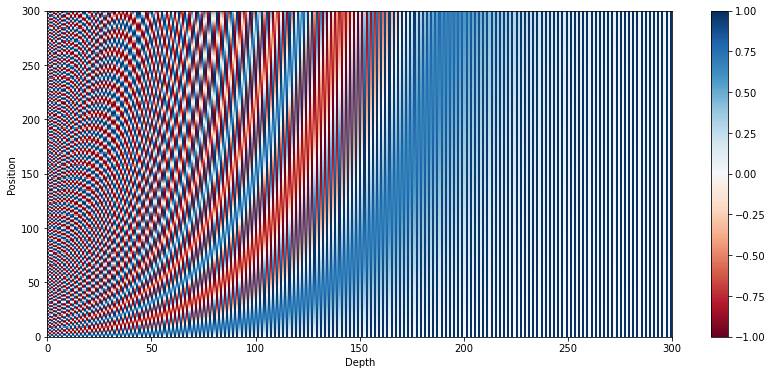

In [21]:
pos_encoding = positional_encoding(300, 300)
print (pos_encoding.shape)

plt.figure(figsize=(14,6))
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 300))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Masking

In [22]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [23]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

# Scaled dot product attention

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True) 

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 

    output = tf.matmul(attention_weights, v) 

    return output, attention_weights

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  
        k = self.wk(k)  
        v = self.wv(v)  

        q = self.split_heads(q, batch_size)  
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size)  

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  

        output = self.dense(concat_attention) 

        return output, attention_weights

In [26]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'), 
      tf.keras.layers.Dense(d_model) 
    ])

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [28]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                   maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, 
                                                   d_model, 
                                                   weights=[embedding_matrix],
                                                   trainable=False) #, weights=[embedding_matrix])
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, 
                                                   d_model, 
                                                   weights=[embedding_matrix],
                                                   trainable=False)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)  
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

# Hyperparameters

In [30]:
num_layers = 4
d_model = EMBEDDING_DIM
dff = 512
num_heads = 8

input_vocab_size = encoder.vocab_size + 2
target_vocab_size = encoder.vocab_size + 2
dropout_rate = 0.1

vocab_size, encoder.vocab_size, input_vocab_size,  target_vocab_size, d_model

(64903, 64905, 64907, 64907, 100)

# Optimizer

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step) + 0.1
        arg2 = step * (self.warmup_steps ** -1.5) + 0.1
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

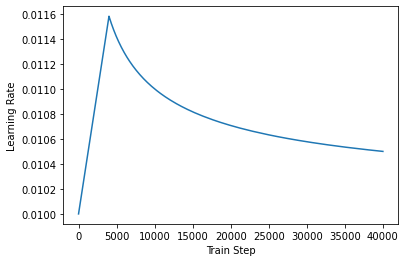

In [32]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
temp_learning_rate_schedule = CustomSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and metrics

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# Training and checkpointing

In [34]:
print('vocabulary   size = ', vocab_size)
print('encoder      size = ', encoder.vocab_size)
print('input_vocab  size = ', input_vocab_size)
print('target_vocab size = ', target_vocab_size)
print('embedding_matrix.shape = ', embedding_matrix.shape)

vocabulary   size =  64903
encoder      size =  64905
input_vocab  size =  64907
target_vocab size =  64907
embedding_matrix.shape =  (64907, 100)


In [35]:
transformer = Transformer(num_layers, 
                          d_model, 
                          num_heads+2, # !!! I add 2 heads to 8
                          dff,
                          input_vocab_size, 
                          target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [36]:
d_model, num_heads

(100, 8)

! ls checkpoints_ATG4/train
transformer.load_weights('./checkpoints_ATG4/train/ckpt-3.index')

In [37]:
tf.keras.utils.plot_model(transformer, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [38]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

In [39]:
!ls

ATG_FINAL_3.ipynb	 Lemmatize_with_postag.ipynb  test.csv
ATG_FINAL_5.ipynb	 MyFastText.py		      title-generation.zip
ATG.ipynb		 new_test.csv		      train.csv
checkpoints_ATG4	 new_train.csv		      vocs.pkl
fasttext_model		 __pycache__
fasttext_train_WE.ipynb  sample_submission.csv


In [40]:
checkpoint_path = "./checkpoints5/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1, checkpoint_name='checkpoint')

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [41]:
EPOCHS = 20

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    print('create Train_Step...')
    tar_inp  = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                  True, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)
    
# validation function
@tf.function
def val_step(inp, tar):
    print('create Test_Step...')
    tar_inp  = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    predictions, _ = transformer(inp, tar_inp, 
                                  True, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
    loss = loss_function(tar_real, predictions)

    val_loss(loss)
    val_accuracy(tar_real, predictions)

In [42]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def dynamic_plot(train, val):
    ax.cla(x)
    ax.plot(train, label='TRAIN ACC')
    ax.plot(val,   label='VAL ACC')
    display(fig)
    clear_output(wait = True)

In [43]:
stored_acc_train, stored_loss_train = [], []
stored_acc_val, stored_loss_val = [], []

PATIENCE = 5
pat_counter = 0

for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    val_loss.reset_states()
    val_accuracy.reset_states()
  
    print(f'EPOCH #{epoch+1} begins here!')
    for (batch, (inp_train, tar_train)) in enumerate(train_dataset):
        train_step(inp_train, tar_train)
        if batch % 100 == 0:
            print (' Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                batch, train_loss.result(), train_accuracy.result()), end=' ')
            tt = time.strftime("%H:%M:%S", time.localtime())
            print (f'TIME: {tt}')
    
    # validation
    for (batch, (inp_val, tar_val)) in enumerate(val_dataset):
        val_step(inp_val, tar_val)
        if batch % 100 == 0:
            print (' Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                batch, val_loss.result(), val_accuracy.result()), end=' ')
            tt = time.strftime("%H:%M:%S", time.localtime())
            print (f'TIME: {tt}')
            
            
    stored_acc_train.append(train_accuracy.result())
    stored_loss_train.append(train_loss.result())
    stored_acc_val.append(test_accuracy.result())
    stored_loss_val.append(test_loss.result())
    
    dynamic_plot(stored_loss_train, stored_loss_val)
    
    if epoch > 3:
        if stored_loss_val[-1] < stored_loss_val[-2]:
            pat_counter = 0
            ckpt_save_path = ckpt_manager.save(checkpoint_number=(epoch+1))
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        else:
            pat_counter += 1
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    if pat_counter == PATIENCE:
        break

EPOCH #1 begins here!
create Train_Step...
create Train_Step...
 Batch 0 Loss 11.0725 Accuracy 0.0000
 Batch 10 Loss 9.0218 Accuracy 0.0151
 Batch 20 Loss 8.4380 Accuracy 0.0160
 Batch 30 Loss 8.1933 Accuracy 0.0163
 Batch 40 Loss 8.0459 Accuracy 0.0165
 Batch 50 Loss 7.9396 Accuracy 0.0166
 Batch 60 Loss 7.8738 Accuracy 0.0166
 Batch 70 Loss 7.7989 Accuracy 0.0167


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

ar1 = [1,6,3,4,5]
ar2 = [5,9,3,3,1]

plt.figure(figsize=(14,6))
plt.title('accuracy')
plt.plot(stored_acc_train, label='TRAIN ACC')
plt.plot(stored_acc_val,   label='VAL ACC')
plt.legend(fontsize='medium')

plt.figure(figsize=(14,6))
plt.title('accuracy')
plt.plot(stored_loss_train, label='TRAIN LOSS')
plt.plot(stored_loss_val,   label='VAL LOSS')
plt.legend(fontsize='medium')

# Evaluate

In [ ]:
import re
word = 'title_NOUN'
re.sub('_.*', '', word)

In [ ]:
def evaluate(inp_sentence, MAX_LENGTH=40):
    start_token = [encoder.vocab_size]
    end_token = [encoder.vocab_size + 1]

    inp_sentence = start_token + encoder.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    decoder_input = [encoder.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        predictions = predictions[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == encoder.vocab_size + 1:
              return tf.squeeze(output, axis=0), attention_weights
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

def pred(sentence):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = encoder.decode([i for i in result if i < encoder.vocab_size]) 
    predicted_sentence = ' '.join([re.sub('_.*', '', word) for word in predicted_sentence.split()])
    predicted_sentence = predicted_sentence[0].title() + predicted_sentence[1:] 
    print('Input: {}'.format(sentence))
    print('Predicted title: {}'.format(predicted_sentence))



num_ex = 34
ex = df_train.iloc[num_ex]['abstract']
pred(ex)
print('Real:' + df_train.iloc[num_ex]['title'])

# Submission

In [ ]:
!ls

In [ ]:
import pandas as pd
submission_data = pd.read_csv('new_test.csv')
abstracts = submission_data['abstract'].values

In [ ]:
titles = []
for abstract in abstracts:
    result, attention_weights = evaluate(abstract)
    title = encoder.decode([i for i in result if i < encoder.vocab_size]) 
    title = ' '.join([re.sub('_.*', '', word) for word in title.split()])
    title = title[0].title() + title[1:]
    titles.append(' '.join(title).replace('<unk>', ''))

In [ ]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('predicted_titles.csv', index=False)

In [ ]:
!ls

In [ ]:
from nltk.util import ngrams
import numpy as np
import pandas as pd
import pickle
import string


def generate_csv(input_file='predicted_titles.csv',
                 output_file='submission.csv',
                 voc_file='vocs.pkl'):

    data = pd.read_csv(input_file)
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')
        
    output_idx = 0
    for row_idx, row in data.iterrows():
        trg = row['title']
        trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
        trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])
        
        VOCAB_stoi = vocs[row_idx]
        trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
        trg_vec = np.zeros(len(VOCAB_stoi))    

        for word in trg_intersection:
            trg_vec[VOCAB_stoi[word]] = 1

        with open(output_file, 'a') as res_file:
            for is_word in trg_vec:
                res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                output_idx += 1

generate_csv('predicted_titles.csv', 
             'kaggle_pred_IPM.csv', 
             'vocs.pkl')

In [ ]:
import pickle

In [ ]:
!wc -l kaggle_pred_IPM.csv

In [ ]:
!head -n 20 kaggle_pred_IPM.csv

In [ ]:
! ls